# Portfolio optimization using simulated annealing, when thermodynamics meets the stock market.

## State of the problem

I was recently following a MOOC on computationnal investing on Coursera and I ended up with the following exercise.
Consider a portfolio made of $N$ equities, each equity contributes to the portfolio at a fraction $w_i$ (naturally $0 \le w_i \le 1$). The problem consists in finding the repartition of the weight $w_i$ that optimizes the Sharpe ratio of the portfolio. The Sharpe ratio is roughly the ratio of the mean daily return over the volatility. The higher is the Sharpe ratio, the lower is the risk so the 'safer' is the portfolio. 

This problem is easy in low dimension, i.e. when the number of equities is low, say $N \le 3$. The solution can be obtained by computing the sharp ratio on a sufficiently well-resolved mesh and then looking for the maximum. 
However, the computation cost is a severe limit to this brute force technique when the number of equities becomes large (computing the Sharpe ratio for 4 equities with $1\%$ resolution already requires $10^8$ iteration!). 

This problem can be adressed with the well known gradient descent method providing the solution is unique. Indeed, if the solution has multiple local maximas, the method is likely to get stucked far from the optimal solution and thus fails. 

Alternative techniques, such as stochastic exploration of the space composed by the weight of the equities (referred to as the parameter space), are generally more suited for this kind of problem. These methods belong to the large class of Monte-Carlo methods. This "exotic" denomination is related to the important role played by randomnes in these methods. This is somehow a reference to the numerous casinos located in Monte-Carlo.

The method is summarized here but will be detailed later on. The parameter space is randomly explored steps by steps, the random jump that leads to a higher Sharpe ratio will be automatically accepted, our explorer thus climbs  little by little the mountain of the Sharpe ratio. Specifity of this methods is that also jumps that lower the Sharê ratio can be accepted with a given probability. This allows our explorer to escape from a local extremum if it gets stuck on a "hill" and then continues his route to the highest peak, the mount Everest of the Sharpe Ratio!





## What makes this problem interesting: the random exploration of a hyperplane!

You can find tons of papers and articles related to optimization with stochastic techniques. What makes this problem particularly interesting, at least to me, is the constraint on the parameters. 
The sum of the weights of the equities should be equal to one, no lower, no greater but exactly equal to one. This imposes a strong constraint on the "authorized" moves. The constraint obviously translates into $\sum_i w_i =1$, which is the equation of a hyperplane of dimension $N-1$ embedded in a space of dimension $N$. 
Let's take the case of 3 equities ($N=3$) to make things more intuitve, 
say my portfolio is made of $x \%$ of Apple, $y\%$ of Facebook and $z\%$ of Twitter (I trust new techs :D )
so that $x+y+z=1$. Et voilà! this is simply the equation of a $2D$ plane in the $3D$ space. 

Now that I convinced you that $\sum_i w_i =1$ is the hyperplane equation, we can try to visualize what means and implies "random exploration of the hyperplane". 

In fact this is a just few big words to stipulate that you are stucked on a given part of the space. We experience this in our daily life, we live in a $3D$ space but most of our motions takes place on the floor (which is generally a plane) as we unfortunately spend much more time walking than flying. Add on the top of that some heavy booze and you will start to walk in an erratic way, which is a good representation of a random walk on a 2-D plane (the floor) embedded in a 3-D space (the physical space).
Don't feel impressed by the hyper- suffix in "hyperplane", this is just the name that planes take in an arbitrary number of dimension. 

##  Implementing the random walk on the hyperplane

The key idea is to start from any point that belongs to the plane and be sure that, while adding random jumps, the explorer stays on that plane. This constraint is automatically fulfilled if the jump corresponds to a vector that is parallel to the plane.

How to do that?

Well that is not too complicated if we remenber basic concepts from Euclidean geometry. We just need to find $N-1$ independent vectors in our plane and then, linear algebra tells us that any linear combinations of these vectors will also form a vector parallel to the plane. 

Before implementing the random walk in Python, let's formalize the idea described above.

### Formal description 


Consider a space of dimension $N$, with the orthonormal basis $\{ \vec x_i \}$ and the origin $O=(0,0,..,0)$, the equation of an arbitrary hyperplane $P$ is $$\sum_{i=1}^N a_i x_i = 1,$$ where ${a_i\neq0}$ are real coefficients . 

The intersection of P with the axis $ \vec x_k$ is $I_k=(0,0,..,1/a_k,0,0,0)$. 

An ensemble of $N-1$ vectors $\vec u_k$  belonging to $P$ can be constructed as $$\vec u_k =  \vec{OI}_k - \vec{OI}_N,$$ for $1 \le k \le N-1 $. 

Let's take the vector $\vec v$ a linear combination of $\{ \vec u_k \} $ such that $$\vec v = \sum_{k=1}^{N-1} b_k \vec u_k,$$ 
with ${b_k}$ real and $b_k\ne0$ for at least one $k$.

If M is a point of P, then the point N defined by $ \vec{ON} = \vec{OM} + \vec v$ also belongs to $P$.

### Python code 

Getting a random jump on a hyperplane is now quite easy, we just have to randomly draw the coefficients ${b_k}$ from a normal distribution (or any other distribution).

The function "RandJumpOnHyerPlane" defined below takes as input:
- the coefficient for the plane equation ${a_i}$
- the characteristics size of the jump 

and returns a random vector called "jump".

In [1]:
def RandJumpOnHyperPlane(planeEq,stepSize):


    import numpy as np
    import numpy.matlib
    
    
    n=len(planeEq) # dimension of the space
    normalVec=planeEq[:] # normal vector to the plane


    # create a n x n matrix filled with zeros, 
    # it will store the coordinates of n intersection points
    pts=np.matlib.zeros((n,n))


    # compute the coordinates of the intersection of the plane
    # with the axis 
    coordIntersectionPoints=[1.]/normalVec

    # the coordinates of the intersection are stored 
    # in the pts matrix column-wise
    di=np.diag_indices(n)
    pts[di]=coordIntersectionPoints

    # next step consist in finding n-1 vectors lying in the plane
    # easy, we just have to construct the vectors that 
    # link the points stored in the matrix pts

    vec=np.matlib.zeros((n-1,n))

    for gi in range(n-1):
        vec[gi,:]=pts[gi,:]-pts[n-1,:]

    # transpose vec to have the vectors columnwize
    vec=vec.T

    # draw n-1 coefficients from a normal distribution
    jumpCoeff=np.random.normal(loc=0,scale=stepSize,size=(n-1,1))

    #The coefficient are used to build a random linear combination 
    # of the plane vectors : the jump vector

    jump=vec*jumpCoeff

    # turn jump into an array
    jump=np.squeeze(np.asarray(jump))
    
    #uncomment the line below to check that the jumps are perpendicular to the normal vector
    #print np.dot(jump,normalVec)
    
    return jump

Now it is time to check that the method works. We simulate two random walks (abreviated RWs) on two planes that are parallel. In this example we consider a $3D$ space that allows us to visualize the RWs.

In [2]:
#----------
# SIMULATE THE RWs
#----------

import numpy as np

# define the planes
planeEq1=np.array([1.,1.,1.])
coeff=.4
planeEq2=planeEq1*coeff

# dimension of the space
nDim=len(planeEq1)

# take start points that belong to the planes
start1=[1./planeEq1[0],0.,0.]
start2=[1./planeEq2[0],0.,0.]

# define the characteristics of the jumps
stepSize1=0.1
stepSize2=stepSize1*coeff

# number of simulated steps
nbStep=1000

# construct two array of size nbStep x nDim to store the 
# position of the walker, and initialize them to the starting points
pos1=np.zeros((nbStep,nDim))
pos1[0,:]=start1

pos2=np.zeros((nbStep,nDim))
pos2[0,:]=start2

for gi in np.arange(1,nbStep):

    jump1=RandJumpOnHyperPlane(planeEq1,stepSize1)
    pos1[gi,:]=pos1[gi-1,:]+jump1
    
    jump2=RandJumpOnHyperPlane(planeEq2,stepSize2)
    pos2[gi,:]=pos2[gi-1,:]+jump2
    
    


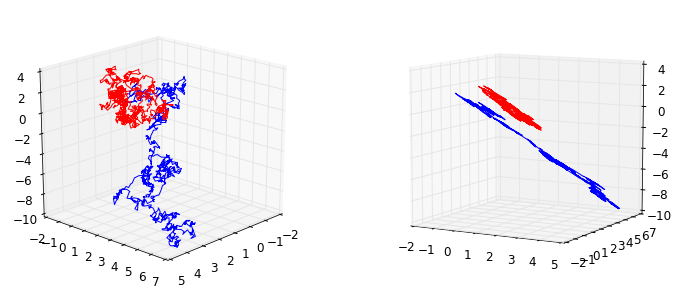

In [3]:
#-------------
# Plot the RWs
#-------------

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# make the fontsize for all plots in this notebook
myFontSize=12
mpl.rcParams['xtick.labelsize'] = 12 
mpl.rcParams['ytick.labelsize'] = 12 
mpl.rcParams['axes.labelsize'] = 14 


%matplotlib inline
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121, projection='3d')
ax.view_init(azim=43,elev=20)
ax.plot(pos1[:,0],pos1[:,1],pos1[:,2],'b')
ax.plot(pos2[:,0],pos2[:,1],pos2[:,2],'r')
ax = fig.add_subplot(122, projection='3d')
ax.view_init(azim=-61,elev=9)
ax.plot(pos1[:,0],pos1[:,1],pos1[:,2],'b')
ax.plot(pos2[:,0],pos2[:,1],pos2[:,2],'r')
plt.show(block=False)


The blue and red curves correspond to RWs in the plane $P_1: x+y+z=1$ and $P_2: x+ y+ z= 2.5$, respectively. 
I have represented the same RWs while using two positions for the camera. The left plot emphasizes the erratic motions while the right plot shows that the RWs indeed lie on parallel planes.

## Application to portfolio's optimization

### Creating a portfolio with historical data from Yahoo Finance

The next step consists in getting historical data for stock prices. This can be easily done via Yahoo Finance for example. I consider here the daily data of different equities such as Facebook, Apple, Microsoft, etc... for the period January 1st 2015 to December 31st 2015. 

The raw data are stored in comma-seperated values (.csv) which is a very common format. Let's translate the data to a more Python-friendly format and then we can have a look to the structure of the data.




In [4]:
def GetYahooData(symbol):
# example for symbol ['AAPL','FB','JPM']

    # the pandas dataframe is a very convenient library to manipulate csv format
    import pandas as pd
    
    # the stocks are stored in a dictionnary, the keys being the symbol
    equities_fullData=dict() 
    
    for s in symbol:
        filename='yahooFinanceData/' + s + '.csv'
        equities_fullData[s]=pd.read_csv(filename)
        
    return equities_fullData

# Quick look at how the data are structured
equities=GetYahooData(['AAPL'])
equities['AAPL'][:10]


,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-31,107.010002,107.029999,104.820000,105.260002,40635300,105.260002
1,2015-12-30,108.580002,108.699997,107.180000,107.320000,25110600,107.320000
2,2015-12-29,106.959999,109.430000,106.860001,108.739998,30848500,108.739998
3,2015-12-28,107.589996,107.690002,106.180000,106.820000,26586600,106.820000
4,2015-12-24,109.000000,109.000000,107.949997,108.029999,13570400,108.029999
5,2015-12-23,107.269997,108.849998,107.199997,108.610001,32468800,108.610001
6,2015-12-22,107.400002,107.720001,106.449997,107.230003,32692300,107.230003
7,2015-12-21,107.279999,107.370003,105.570000,107.330002,43690600,107.330002
8,2015-12-18,108.910004,109.519997,105.809998,106.029999,95733800,106.029999
9,2015-12-17,112.019997,112.250000,108.980003,108.980003,44554400,108.980003


The table above shows the Apple's stock data for the last 10 days of 2015. We don't need all this information 
to build the portfolio, only the 'Adj Close' column will be used. 

In summary, in order to create a portfolio we need to:
- get the stocks price
- select only the 'Adj Close' values for the equities, note that the data are not sorted chronologically, which is a bit inconvenient. I therefore change the order of the data such that the 01/01/2015 comes first
- normalize the stock prices to their values at day one $$\tilde V_{i,eq}=V_{i,eq}/V_{0,eq},$$ where $V_{i,eq}$ is the adjusted close price for the equities $eq$ on day $i$.
- compute the normalized value of the portfolio for day $i$: $$p_i =\sum_{eq} w_{eq} \tilde V_{i,eq}.$$ 

These sucessive steps are implemented in the CreatePortfolio.py. The function takes two inputs:
- an array of symbols for the equities
- an array with the corresponding weights.

The function returns the normalized portfolio value as well as the evolution of the normalized value for each equity. 

In [5]:
def CreatePortfolio(equities,weight):
    #ex: equities=['AAPL','FB','JPM']
    #ex: weight=[0.25,0.5,0.25]
    
    import numpy as np


    nbEquities=len(equities) #number of equities
    nbTradingDay=252 #number of trading days

    equities_fullData=GetYahooData(equities) 
    
    #Create dictionnaries to store adjusted close values and normalize values
    equities_adjCloseVal=dict()
    equities_norm=dict()
    
    # get  the adjusted close values, reverse the order,  and normaliz to day 1
    for symbol in equities:

        #get the close value
        equities_adjCloseVal[symbol]=np.array(equities_fullData[symbol]['Adj Close'].values)

        # reverse order of the array to have first day : first position
        equities_adjCloseVal[symbol]=equities_adjCloseVal[symbol][::-1]

        #normalize price
        equities_norm[symbol]=equities_adjCloseVal[symbol]/equities_adjCloseVal[symbol][0]


    #Store the daily normalized value in a single matrix
    dailyNormVal=np.zeros((nbTradingDay,nbEquities))

    for gi in range(nbEquities):

        dailyNormVal[:,gi]=equities_norm[equities[gi]]

    # weighted normalized price
    weiPF=dailyNormVal*weight
    
    # the normalized value of the portfolio is the sum of the weighted normalized price
    cumPF=np.sum(weiPF,axis=1)
    
    return cumPF, dailyNormVal

Let's check if the function works well by creating a portfolio composed of $50\%$ Apple shares, $20\%$ Facebook shares and $30\%$ Twitter shares. 

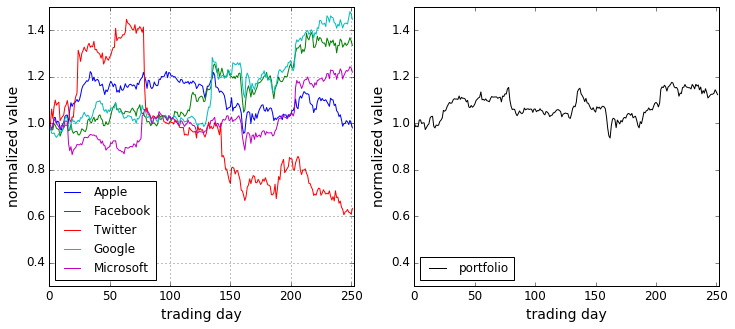

In [7]:
#-------------------------------------------------
# Test of CreatePorfolio.py and visualization of the
# evolution of the values
#-------------------------------------------------

equities=['AAPL','FB','TWTR','GOOG','MSFT']
weight=[0.2,0.2,0.2,0.2,0.2]
portfolio,eqPrice=CreatePortfolio(equities,weight)

# Make some plots

fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(121)
plt.plot(eqPrice)
plt.xlabel('trading day')
plt.ylabel('normalized value')
plt.xlim([0,252])
plt.ylim([0.3,1.5])
plt.legend(['Apple','Facebook','Twitter','Google','Microsoft'],loc=3)
plt.grid()


ax = fig.add_subplot(122)
plt.plot(portfolio,'k')
plt.xlabel('trading day')
plt.ylabel('normalized value')
plt.xlim([0,252])
plt.ylim([0.3,1.5])
plt.legend(['portfolio'],loc=3)


The normalized portfolio's value (right plot) increases rapidly during the first trading days beacause of the good performance of Apple and Twitter (left plot). In the second stage of the year, the value of Twitter drastically drops but is compensated by the increase of the value of Facebook, Google and Microsoft. 

At the end of the year, the normalized value of the portfolio is about  $\sim 1.12$. 
In other words, this means that if you have invested 100 k€ on this portfolio on 01/01/2015, and if you decided to sell it on 31/12/2015, there was a net gain of 12 k€. Not too bad! 
But maybe we could even have done a better operation if we did not allocate the same weight to all the equities.


### The performance of the portfolio can be quantified with the Sharpe ratio

The evolution of the portfolio can also be studied through the daily returns defined as $r_{i}=p_i/p_{i-1}-1$ (the daily return at day 1 is set to zero). 

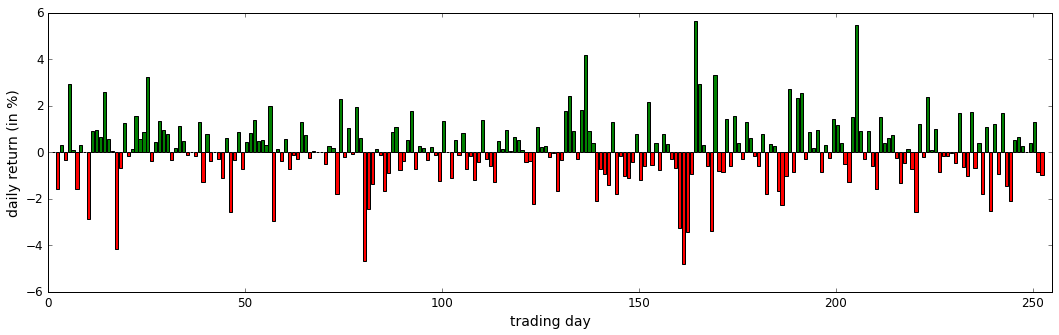

In [8]:
def DailyReturn(data):
    
    import numpy as np
    
    nbEl=len(data)
    
    dR_day1=np.array([0])
    
    dailyRet=data[1:]/data[:nbEl-1]-1
    
    dailyRet=np.concatenate((dR_day1,dailyRet))
    
    return dailyRet



#plot the daily return
r=DailyReturn(portfolio)
idPos=np.where(r >=0)
idNeg=np.where(r < 0)
trDay=np.arange(1,253)

plt.figure(figsize=(18,5))
plt.bar(trDay[idPos],r[idPos]*100, facecolor='green')
plt.hold
plt.bar(trDay[idNeg],r[idNeg]*100, facecolor='red')
plt.xlabel('trading day')
plt.ylabel('daily return (in %)')
plt.xlim([0 , 255]);






While both positive and negative daily returns occur during the year, there is an excedent of positive returns that leads to a net gain of value of the portfolio.

Vizualising the daily evolution of a portfolio is great but people also like to summarize information in one single number since it facilitates the comparison between the performance of different portfolios. 
I guess there is tons of indices to do so but we will focus here on the Sharpe ratio.
Considering a total of $N_D$ trading days, the Sharpe ratio is defined as: $$S=\frac{\bar r - r_f} {\sigma_r}  \times \sqrt{N_D}\sim \frac{\bar r } {\sigma_r}  \times \sqrt{N_D} ,$$
where $\bar r$ and $\sigma_r$ are the mean and standard deviation of the daily return, respectively.
The term $r_f$ respresents the risk free rate of return, it will be neglected in our analysis ($r_f=0$) since there is no such things as a risk-free investment!

You can see that the Sharpe ratio is a measure that how much you can earn (the mean daily return) with respect to the risk you take (the daily return standard deviation, or daily volatility). A performant portfolio should have a high Sharpe ratio, meaning that it has a high expected return while taking low risks.

Given that our portfolio has $\bar r \sim 5.5 \times 10^{-4}$ and $\sigma_r \sim 1.4 \times 10^{-2}$, the Sharpe ratio is $S\sim0.63$, which is OK but not optimal. 



## Optimizing the Sharpe ratio using simulated annealing

We are now close to our final goal that is to find which weights for equities lead to the best portfolio, namely the portfolio with the highest Sharpe ratio.
We have almost all the ingredients to do so since we know how to
- create and assess the performance of a portfolio composed of N equities with weight ${w_i}$ 
- explore randomly the hyperplane of the weight of equities such that $\sum_i w_i=1$ 

It only remains to define a method to guide the explorer far from the low valleys of the Sharpe ration, right toward the highest peaks! The method we employ to achieve this is called simulated annealing as it shares some similarities with the process of metal annealing in thermodynamics. 




### Short description of the simulated annealing algorithm

Simulated annealing is a standard method of stochastic optimization that is extensively detailed in the litterature. 
I will therefore only provide the elements required to make the code understanable. If you want to know more about it, just google "simulated annealling", there are plenty of web pages that explain the algorithm in great details.

The algorithm is fairly simple:
1. Start at a random position $\vec{\Omega}_0=(w_{0,1},w_{0,2},....,w_{0,N})$ so that $\sum_j w_{0,j}=1$
2. From the position $\vec {\Omega}_i$ with Sharp Ratio $S_i$ jump randomly on the hyperplane to position $\vec {\omega}_{i+1}$ and compute the corresponding Sharpe ratio $S_{i+1}$.
3. Accept the move with proability $$ \text{prob}( S_{i+1},S_i,T)= exp((S_i-S_{i+1})/T) $$
4. cool the temperature $T$ every $M$ accepted moves
5. iterate until the process converges.

While step 1 and 2 are quite trivial, steps 3 and 4 may require additionnal discussions. 

The analogy with thermodynamics shows up in step 3 where we decide if the move should be accepted or not based on the value of the function $exp(-(S_i-S_{i+1})/T)$. This function looks pretty much like to the Boltzmann distribution,  which describes the probability for a system to be in a specific state given the energy of this state and the temperature of the system.

In our situation, the condition in step 3 leads to two distinct cases:
- if $S_{i+1} > S_i$, the new move leads to a better solution (higher Sharpe ratio). The move is automatically accepted since $exp(-(S_i-S_{i+1})/T) > 1 $.
- if $S_{i+1} \le S_i$, the move is not always rejected but can be accepted if $S_{i+1}$  is $\textit{"close enough"}$ to $S_i$. The meaning of $\textit{"close enough"}$ is determined by the temperature T. For large temperature, the term $(S_i-S_{i+1})/T$ can be quite small even if $S_{i+1} << S_i$ leading to a substantial probability to accept the move. On the contrary, if the temperature T is very low, $S_{i+1}$ should be very close to $S_i$ so that the probability to accept the move remains relatively large. 

We can now easily understand step 4, which consists in progressively lowering the temperature during the iteration. We start with a large temperature in order to explore many solutions, even those that are not so good. After $M$ iterations, we reduce the temperature such that only high Sharpe ratio are accepted. 

We can not really determined the best values for the initial temperature and "rate of cooling" parameter $M$ 
as they are generally problem-dependent. However, the convergence of the algorithm does not strongly depend on these values, which is certainly one of the strength of this method.

Finally, I should say that there is no guarantee that the algorithm converges to THE optimal solution in a finite amount of time. However, it generally provides a solution very close to the optimal in a reasonnable amount of time.



### Python code


In [9]:
#-----------
# check that every element of the array pos is within boundMin and boundMax
#-----------

def CheckBound(pos,boundMin,boundMax):

    import numpy as np
    
    # pos must be a np.array
    return np.all( pos > [boundMin] ) &  np.all( pos < [boundMax] )

In [10]:
#---------------------
# Portfolio Optimization
#---------------------

import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
import func_OptimizePortfolioMCMC as opf
from scipy.stats import norm


# possible equities "AAPL","FB",'GE','GM','GOOG','JPM','MSFT','SP500','TWTR','XOM', 'YHOO'
equities=['AAPL','FB','TWTR','GOOG','MSFT'] 
nbEquities=len(equities)
nbDay=252

# coefficients for the equation of the hyperplane
# since the sum of weight is 1 this is simply [1.,1.,...,1.]
planeEq=np.ones(nbEquities)



# Parameters for the cooling process
tempFactorMax=0.8
tempFactorMin=0.5*10**-2
coolingFactor=0.8
M=100 # cooling rate

# number of steps required to cool down to tempFactorMin
nbStep=(np.log(tempFactorMin)-np.log(tempFactorMax))/np.log(coolingFactor)*M
nbStep=np.round(nbStep)+2*M # we add 2 times the cooling rate to ensure convergence

# Preallocate memory
weight=np.zeros((nbStep,nbEquities))
sharpeRatio=np.zeros(nbStep)


# Initialization

start=1./nbEquities*np.ones(nbEquities) # The starting point is taken as the "center" of the hyperplane

weight[0,:]=start

portfolio, dum = CreatePortfolio(equities,start)
r=DailyReturn(portfolio)
sharpeRatio[0]=np.mean(r)/np.std(r)*np.sqrt(nbDay)

tempFactor=tempFactorMax
T=sharpeRatio[0]*tempFactor

gi=1 # number of accepted move
gTest=0 # total number of move (accepted and rejected)

# characteristics size for the jump in the hyperplane
stepSize=0.02

# The weight are bounded 0. <= w_i <= 1.
boundMin=0.
boundMax=1.


while gi < nbStep :
    
    gTest+=1
    
    # generate a random jump on the hyerplane
    jump=RandJumpOnHyperPlane(planeEq,stepSize)
    
    # check that 0 <= w_i <= 1 is fulfilled for every equities, 
    # if not reject the move
    if CheckBound(weight[gi-1,:]+jump, boundMin, boundMax ):
        
        # update the weights
        weightTmp=weight[gi-1,:]+jump
        
        #compute the portfolio
        portfolio, dum = CreatePortfolio(equities,weightTmp)
        
        #compute daily returns
        r=DailyReturn(portfolio)
        
        #compute Sharpe ratio
        sharpeTmp=np.mean(r)/np.std(r)*np.sqrt(nbDay)
        
        
        # evaluate the difference between the old and new Sharpe ratios
        costFunc=sharpeRatio[gi-1]-sharpeTmp
        
        # accept or reject the move
        if np.exp(-costFunc/T) > np.random.rand() and sharpeTmp > 0:
            
            # if the move is accepted update the random walk
            weight[gi,:]=weightTmp
            sharpeRatio[gi]=sharpeTmp
            gi+=1
            
        # cool the temperature every M steps
        if gi%M == 0 and tempFactor >= tempFactorMin:            
           
            tempFactor=tempFactor*coolingFactor
            T=sharpeTmp*tempFactor
            

        



/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [11]:

# Print optimal weight
idMax=np.argmax(sharpeRatio)
print 'max Sharpe Ratio: ' + repr(np.max(sharpeRatio))

optimalWeights=dict()
for gi in range(nbEquities):
    optimalWeights[equities[gi]]=weight[idMax,gi]

print 'Optimal weights: ' + repr(optimalWeights,)


max Sharpe Ratio: 1.4731039487401358
Optimal weights: {'GOOG': 0.52412409381160974, 'TWTR': 6.994644770204686e-05, 'AAPL': 0.0043335476285206983, 'FB': 0.47023861855837407, 'MSFT': 0.0012337935537916102}


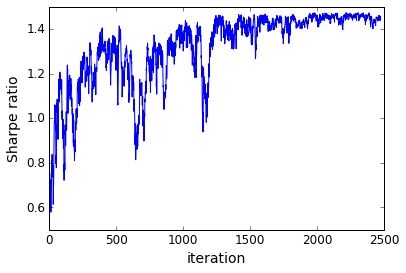

In [12]:
#Plot the evolution of the Sharpe ratio
plt.plot(sharpeRatio)
plt.xlabel('iteration')
plt.ylabel('Sharpe ratio')


The algorithm converges after about 1500 iterations. The maximum Sharpe ratio $\sim~1.47$  is obtained by allocating about $52\ \%$ and $47 \ \%$ Google and Facebook shares, respectively. The rest of the equities contributes for less than $1\ \%$ to the portfolio value.

# Discussion

After doing some maths and a bit of programming, we were able to more than double the performance of the portfolio. Remember than a homogeneous repartition of the equities (Apple, Google, Facebook, Twitter and Microsoft) led to a Sharpe ratio $\sim 0.63$ whereas the Sharpe ratio associated to the optimal solution is $\sim 1.47$. 

Eventough the problem was addressed through a simple description of an idealized situation, I personnally think it constitute an interesting exercise  where both linear algebra and stochastic process were used to find the (almost) optimal solution.


Last comments before closing this post:
- The Sharpe ratio may not be the best index to evaluate the performance of a portfolio (as mentionned above, many indices exist). The Sharpe ratio penalizes both positive and negative variations. This is clearly a drawback since large positive variations lower the Sharpe ratio but lead to high returns. Nevertheless, the whole model can be applied to any other scalar indices.
- My laptop needs couple of minutes to compute $5\times10^3$ iterations when I consider 5 equities, which is acceptable. However, the computing time may significantly increase with the number of equities. Why? This problem is described in the litterature as "the curse of dimensionality": high dimensional space tends to be terribly empty! The probability to be in an "interesting" region of the space (where the Sharpe ratio is large) rapidly decreases with the number of dimensions. For a large number of equities, our dear walker will therefore loose his time exploring dead-end paths. This leads to a lower ratio of accepted moves over rejected moves, and therefore reduces the performance of the algorithm.
